In [2]:
from aqua import Reader,catalogue, inspect_catalogue
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
cat = catalogue()

In [4]:
# We are not looking at scientific validity in the data now. 
# AQUA reader. One note: regrider is not working for 3d variables
reader = Reader(model = 'FESOM', exp = 'tco3999-ng5', source="interpolated_global_TS") 
data = reader.retrieve()

# Dropping the variables, which are not required
data=data.drop("lat")
data=data.drop("lon")
data=data.drop("ocpt")
data=data.coarsen(lat=30, lon=40).mean()  #Here will not use AQUA regridder, because it's just fake thing

# Renaming the Variables
data=data.rename({"salt":"so"})
data=data.rename({"temp":"thetao"})
data=data.rename({"depth":"lev"})

# Faking some changes in date for our next codes
data = data.resample(time='7.39H').mean() 
time = np.arange('2011-01-01', '2013-01-01', dtype='datetime64[D]')
data["time"]=time
data["lev"]=data.lev*100

In [50]:
# There is a issue that if I dont save it and go for the next test without 
data=xr.open_dataset("./../../../data.nc")
data["lev"]=data.lev*100

In [51]:
# FIRST WE LOAD THE MODEL DATA
# We load first temperature data (in a regular grid)
simS=data.drop("thetao")
simT=data.drop("so")

# WE LOAD TWO OBS CLIMATOLOGIES NOW JUST AFTERWARDS (this would require copying the data across to Levante)
obsS1=data.drop("thetao")
obsT1=data.drop("so")
obsS2=data.drop("thetao")
obsT2=data.drop("so")

In [53]:
# We produce weights (for the regular grid)
weights=np.cos(np.deg2rad(simT.lat)) # Weights are proportional to the grid cell area, which is influenced by the lats
oweights=np.cos(np.deg2rad(obsT1.lat))

In [54]:
# We extract the variables and compute their yearly means
t3d=simT.thetao.resample(time="Y").mean()
s3d=simS.so.resample(time="Y").mean()
nyr=t3d.time.size

In [55]:
# We compute the temporal means for their whole period, for the first half and for the second half
t3d_tm=t3d.mean(("time"))
s3d_tm=s3d.mean(("time"))
if nyr == 1: # We check first is the timeseries is only 1 year long (in which case it cannot be split in two periods)
    t3d_tm1=t3d_tm
    t3d_tm2=t3d_tm
    s3d_tm1=s3d_tm
    s3d_tm2=s3d_tm
elif nyr % 2: # This condition is true if the nyr is odd
    iyr1=0
    iyr2=int(nyr/2)
    fyr1=(int(nyr/2)+1)
    fyr2=int(nyr)-1
    # The mean of the first half
    t3d_tm1=t3d[iyr1:iyr2,:,:,:].mean(("time"))
    s3d_tm1=s3d[iyr1:iyr2,:,:,:].mean(("time"))
    # The mean of the second half
    t3d_tm2=t3d[fyr1:fyr2,:,:,:].mean(("time"))
    s3d_tm2=s3d[fyr1:fyr2,:,:,:].mean(("time"))
else: # If nyr is even
    iyr1=0
    iyr2=int(nyr/2)-1
    fyr1=(int(nyr/2))
    fyr2=(int(nyr)-1)
    # The mean of the first half
    t3d_tm1=t3d[iyr1:iyr2,:,:,:].mean(("time"))
    s3d_tm1=s3d[iyr1:iyr2,:,:,:].mean(("time"))
    # The mean of the second half
    t3d_tm2=t3d[fyr1:fyr2,:,:,:].mean(("time"))
    s3d_tm2=s3d[fyr1:fyr2,:,:,:].mean(("time"))

In [56]:
## We select the Labrador Sea region
t3d_tm1_ls=t3d_tm1.sel(lat=slice(50,65), lon=slice(300,325))
s3d_tm1_ls=s3d_tm1.sel(lat=slice(50,65), lon=slice(300,325))

t3d_tm2_ls=t3d_tm2.sel(lat=slice(50,65), lon=slice(300,325))
s3d_tm2_ls=s3d_tm2.sel(lat=slice(50,65), lon=slice(300,325))

# Weights are proportional to the grid cell area, which is influenced by the latd
weights_ls=np.cos(np.deg2rad(s3d_tm2_ls.lat)) 

t3d_tm1_ls_w=t3d_tm1_ls.weighted(weights_ls)
s3d_tm1_ls_w=s3d_tm1_ls.weighted(weights_ls)
t3d_tm2_ls_w=t3d_tm2_ls.weighted(weights_ls)
s3d_tm2_ls_w=s3d_tm2_ls.weighted(weights_ls)

# t3d_tm_ls[1,:,:].plot()   # To verify that it's the Labrador Sea!

In [57]:
## We select the Labrador Sea region
obsT1_ls=obsT1.sel(lat=slice(50,65), lon=slice(300,325))
obsT2_ls=obsT2.sel(lat=slice(50,65), lon=slice(300,325))
obsS1_ls=obsS1.sel(lat=slice(50,65), lon=slice(300,325))
obsS2_ls=obsS2.sel(lat=slice(50,65), lon=slice(300,325))

# Weights are proportional to the grid cell area, which is influenced by the latd
oweights_ls=np.cos(np.deg2rad(obsT1_ls.lat)) 

obsT1_ls_w=obsT1_ls.weighted(oweights_ls)
obsT2_ls_w=obsT2_ls.weighted(oweights_ls)
obsS1_ls_w=obsS1_ls.weighted(oweights_ls)
obsS2_ls_w=obsS2_ls.weighted(oweights_ls)

In [58]:
# And we compute the box average
t3d_tm1_ls_av=t3d_tm1_ls_w.mean(("lat","lon"))
s3d_tm1_ls_av=s3d_tm1_ls_w.mean(("lat","lon"))
t3d_tm2_ls_av=t3d_tm2_ls_w.mean(("lat","lon"))
s3d_tm2_ls_av=s3d_tm2_ls_w.mean(("lat","lon"))
obsT1_ls_w_av=obsT1_ls_w.mean(("lat","lon"))
obsT2_ls_w_av=obsT2_ls_w.mean(("lat","lon"))
obsS1_ls_w_av=obsS1_ls_w.mean(("lat","lon"))
obsS2_ls_w_av=obsS2_ls_w.mean(("lat","lon"))

In [59]:
# Here we compute the density values at 0 level. For that we use the Equation of State that requires absolute salinity and conservative temperature as inputs
# First we introduce a function to convert practical salinity to absolute salinity
def convert_so(so):
    """
    Convert practical salinity to absolute.

    Parameters
    ----------
    so: dask.array.core.Array
        Masked array containing the practical salinity values (psu or 0.001).

    Returns
    -------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values (g/kg).

    Note
    ----
    This function use an approximation from TEOS-10 equations and could
    lead to different values in particular in the Baltic Seas.
    http://www.teos-10.org/pubs/gsw/pdf/SA_from_SP.pdf

    """
    return so / 0.99530670233846
# And we compute absolute salinity 
obsaS1_ls_w_av=convert_so(obsS1_ls_w_av.so)
obsaS2_ls_w_av=convert_so(obsS2_ls_w_av.so)
as3d_tm1_ls_av=convert_so(s3d_tm1_ls_av)
as3d_tm2_ls_av=convert_so(s3d_tm2_ls_av)

In [60]:
# Here we introduce a function to convert potential temperature to conservative temperature
def convert_thetao(absso, thetao):
    """
    Parameters
    ----------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values.
    thetao: dask.array.core.Array
        Masked array containing the potential temperature values (degC).

    Returns
    -------
    bigthetao: dask.array.core.Array
        Masked array containing the conservative temperature values (degC).

    Note
    ----
    http://www.teos-10.org/pubs/gsw/html/gsw_CT_from_pt.html

    """
    x = np.sqrt(0.0248826675584615*absso)
    y = thetao*0.025e0
    enthalpy = 61.01362420681071e0 + y*(168776.46138048015e0 +
        y*(-2735.2785605119625e0 + y*(2574.2164453821433e0 +
        y*(-1536.6644434977543e0 + y*(545.7340497931629e0 +
        (-50.91091728474331e0 - 18.30489878927802e0*y)*
        y))))) + x**2*(268.5520265845071e0 + y*(-12019.028203559312e0 +
        y*(3734.858026725145e0 + y*(-2046.7671145057618e0 +
        y*(465.28655623826234e0 + (-0.6370820302376359e0 -
        10.650848542359153e0*y)*y)))) +
        x*(937.2099110620707e0 + y*(588.1802812170108e0+
        y*(248.39476522971285e0 + (-3.871557904936333e0-
        2.6268019854268356e0*y)*y)) +
        x*(-1687.914374187449e0 + x*(246.9598888781377e0 +
        x*(123.59576582457964e0 - 48.5891069025409e0*x)) +
        y*(936.3206544460336e0 +
        y*(-942.7827304544439e0 + y*(369.4389437509002e0 +
        (-33.83664947895248e0 - 9.987880382780322e0*y)*y))))))

    # bigthetao = enthalpy/Specific heat
    return enthalpy/3991.86795711963
# And we compute conservative temperature 
obscT1_ls_w_av=convert_thetao(obsaS1_ls_w_av,obsT1_ls_w_av.thetao)
obscT2_ls_w_av=convert_thetao(obsaS2_ls_w_av,obsT2_ls_w_av.thetao)
ct3d_tm1_ls_av=convert_thetao(as3d_tm1_ls_av,t3d_tm1_ls_av)
ct3d_tm2_ls_av=convert_thetao(as3d_tm2_ls_av,t3d_tm2_ls_av)

#diff=obscT2_ls_w_av-obsT2_ls_w_av.thetao
#diff.plot()

In [61]:
# Finally we compute the potential in-situ density
# First we define the associated function
def compute(absso, bigthetao, ref_pressure):
    """
    Computes the potential density in-situ.

    Parameters
    ----------
    absso: dask.array.core.Array
        Masked array containing the absolute salinity values (g/kg).
    bigthetao: dask.array.core.Array
        Masked array containing the conservative temperature values (degC).
    ref_pressure: float
        Reference pressure (dbar).

    Returns
    -------
    rho: dask.array.core.Array
        Masked array containing the potential density in-situ values (kg m-3).

    Note
    ----
    https://github.com/fabien-roquet/polyTEOS/blob/36b9aef6cd2755823b5d3a7349cfe64a6823a73e/polyTEOS10.py#L57

    """
    # reduced variables
    SAu = 40.*35.16504/35.
    CTu = 40.
    Zu = 1e4
    deltaS = 32.
    ss = np.sqrt((absso+deltaS)/SAu)
    tt = bigthetao / CTu
    pp = ref_pressure / Zu

    # vertical reference profile of density
    R00 = 4.6494977072e+01
    R01 = -5.2099962525e+00
    R02 = 2.2601900708e-01
    R03 = 6.4326772569e-02
    R04 = 1.5616995503e-02
    R05 = -1.7243708991e-03
    r0 = (((((R05*pp + R04)*pp + R03)*pp + R02)*pp + R01)*pp + R00)*pp

    # density anomaly
    R000 = 8.0189615746e+02
    R100 = 8.6672408165e+02
    R200 = -1.7864682637e+03
    R300 = 2.0375295546e+03
    R400 = -1.2849161071e+03
    R500 = 4.3227585684e+02
    R600 = -6.0579916612e+01
    R010 = 2.6010145068e+01
    R110 = -6.5281885265e+01
    R210 = 8.1770425108e+01
    R310 = -5.6888046321e+01
    R410 = 1.7681814114e+01
    R510 = -1.9193502195e+00
    R020 = -3.7074170417e+01
    R120 = 6.1548258127e+01
    R220 = -6.0362551501e+01
    R320 = 2.9130021253e+01
    R420 = -5.4723692739e+00
    R030 = 2.1661789529e+01
    R130 = -3.3449108469e+01
    R230 = 1.9717078466e+01
    R330 = -3.1742946532e+00
    R040 = -8.3627885467e+00
    R140 = 1.1311538584e+01
    R240 = -5.3563304045e+00
    R050 = 5.4048723791e-01
    R150 = 4.8169980163e-01
    R060 = -1.9083568888e-01
    R001 = 1.9681925209e+01
    R101 = -4.2549998214e+01
    R201 = 5.0774768218e+01
    R301 = -3.0938076334e+01
    R401 = 6.6051753097e+00
    R011 = -1.3336301113e+01
    R111 = -4.4870114575e+00
    R211 = 5.0042598061e+00
    R311 = -6.5399043664e-01
    R021 = 6.7080479603e+00
    R121 = 3.5063081279e+00
    R221 = -1.8795372996e+00
    R031 = -2.4649669534e+00
    R131 = -5.5077101279e-01
    R041 = 5.5927935970e-01
    R002 = 2.0660924175e+00
    R102 = -4.9527603989e+00
    R202 = 2.5019633244e+00
    R012 = 2.0564311499e+00
    R112 = -2.1311365518e-01
    R022 = -1.2419983026e+00
    R003 = -2.3342758797e-02
    R103 = -1.8507636718e-02
    R013 = 3.7969820455e-01

    rz3 = R013*tt + R103*ss + R003
    rz2 = (R022*tt+R112*ss+R012)*tt+(R202*ss+R102)*ss+R002
    rz1 = (((R041*tt+R131*ss+R031)*tt +
            (R221*ss+R121)*ss+R021)*tt +
           ((R311*ss+R211)*ss+R111)*ss+R011)*tt + \
        (((R401*ss+R301)*ss+R201)*ss+R101)*ss+R001
    rz0 = (((((R060*tt+R150*ss+R050)*tt +
              (R240*ss+R140)*ss+R040)*tt +
             ((R330*ss+R230)*ss+R130)*ss+R030)*tt +
            (((R420*ss+R320)*ss+R220)*ss+R120)*ss+R020)*tt +
           ((((R510*ss+R410)*ss+R310)*ss+R210)*ss+R110)*ss+R010)*tt + \
        (((((R600*ss+R500)*ss+R400)*ss+R300)*ss+R200)*ss+R100)*ss+R000
    r = ((rz3*pp + rz2)*pp + rz1)*pp + rz0

    # in-situ density
    return r + r0

# And we compute the in-situ density for the reference level 0  
obsarho01_ls_w_av=compute(obsaS1_ls_w_av,obscT1_ls_w_av,0)
obsarho02_ls_w_av=compute(obsaS2_ls_w_av,obscT2_ls_w_av,0)
rho03d_tm1_ls_av=compute(as3d_tm1_ls_av,ct3d_tm1_ls_av,0)
rho03d_tm2_ls_av=compute(as3d_tm2_ls_av,ct3d_tm2_ls_av,0)


ValueError: x and y must have same first dimension, but have shapes (731, 21) and (21,)

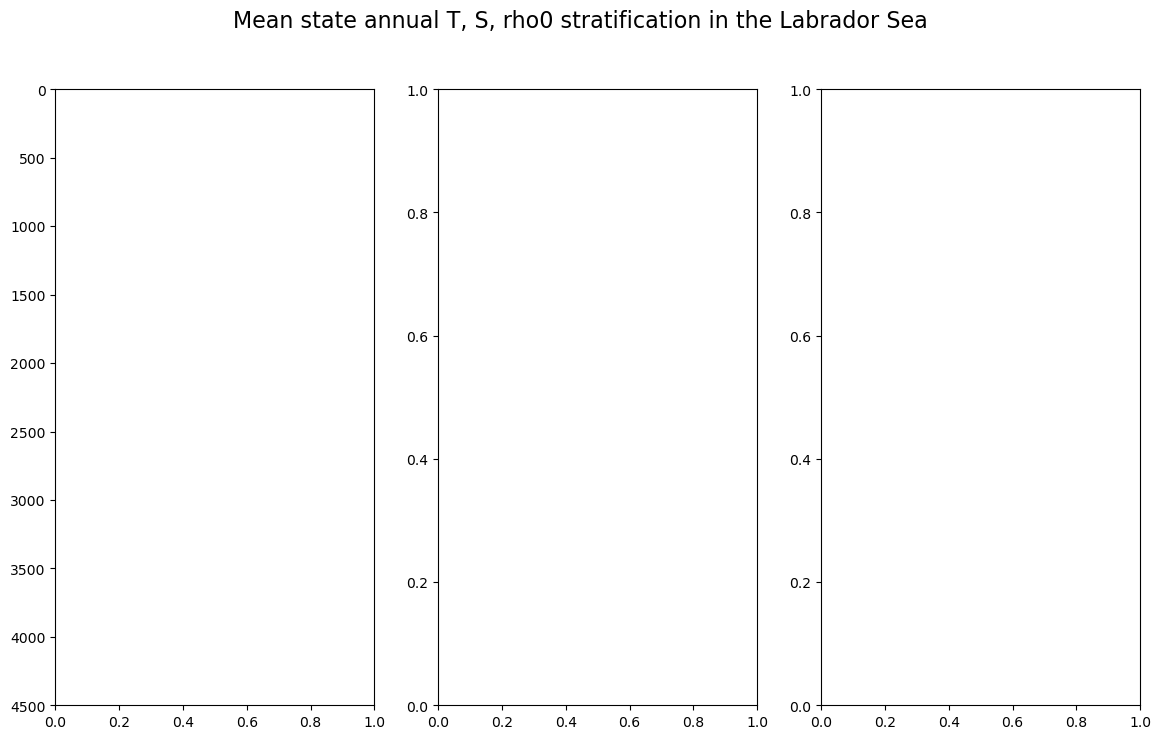

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14,8))
fig.suptitle('Mean state annual T, S, rho0 stratification in the Labrador Sea', fontsize=16)

ax1.set_ylim((4500,0))

# ax1.plot(t3d_tm1_ls_av,t3d_tm1_ls_av.lev,'g-',linewidth=2.0)
ax1.plot(obsT1_ls_w_av.thetao,obsT1_ls_w_av.thetao.lev,'k:')

ValueError: x and y must have same first dimension, but have shapes (731, 21) and (21,)

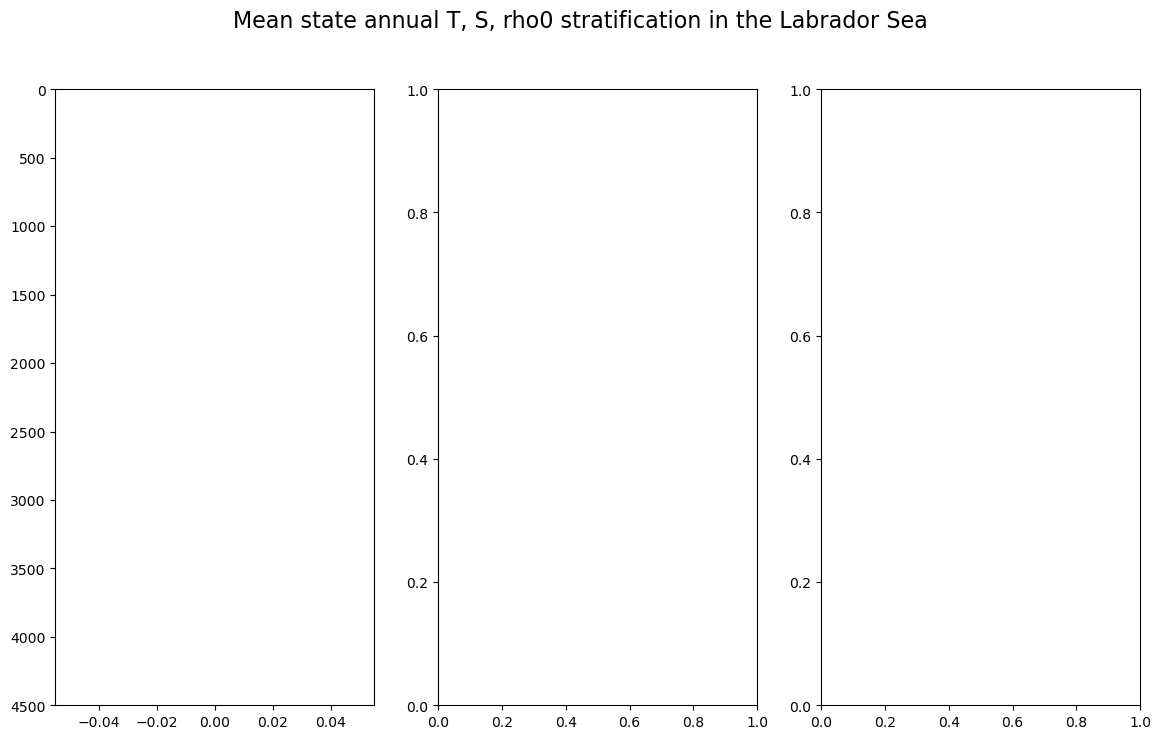

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14,8))
fig.suptitle('Mean state annual T, S, rho0 stratification in the Labrador Sea', fontsize=16)

ax1.set_ylim((4500,0))

ax1.plot(t3d_tm1_ls_av,t3d_tm1_ls_av.lev,'g-',linewidth=2.0)
ax1.plot(t3d_tm2_ls_av,t3d_tm2_ls_av.lev,'b-',linewidth=2.0)


ax1.plot(obsT1_ls_w_av.thetao,obsT1_ls_w_av.thetao.lev,'k:')
ax1.plot(obsT2_ls_w_av.thetao,obsT2_ls_w_av.thetao.lev,'k--')

ax1.set_title("Temperature Profile", fontsize=14)
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Temperature (in degC)",fontsize=12)
ax1.legend(["EXP first half","EXP last half","EN4 1950-1980","EN4 1990-2020"], loc='best')


# Now we plot salinity
ax2.set_ylim((4500,0))

ax2.plot(s3d_tm1_ls_av,s3d_tm1_ls_av.lev,'g-',linewidth=2.0)
ax2.plot(s3d_tm2_ls_av,s3d_tm2_ls_av.lev,'b-',linewidth=2.0)


ax2.plot(obsS1_ls_w_av.so,obsS1_ls_w_av.so.lev,'k:')
ax2.plot(obsS2_ls_w_av.so,obsS2_ls_w_av.so.lev,'k--')

ax2.set_title("Salinity Profile", fontsize=14)
ax2.set_xlabel("Salinity (in psu)",fontsize=12)
#ax1.legend(["EXP","EN4 1950-1980","EN4 1990-2020"], loc='best')
#ax2.legend(["EXP","EN4 1950-1980","EN4 1990-2020"], loc='best')

ax3.set_ylim((4500,0))

ax3.plot(rho03d_tm1_ls_av-1000,rho03d_tm1_ls_av.lev,'g-',linewidth=2.0)
ax3.plot(rho03d_tm2_ls_av-1000,rho03d_tm2_ls_av.lev,'b-',linewidth=2.0)


ax3.plot(obsarho01_ls_w_av-1000,obsarho01_ls_w_av.lev,'k:')
ax3.plot(obsarho02_ls_w_av-1000,obsarho02_ls_w_av.lev,'k--')

ax3.set_title("Rho (ref 0) Profile", fontsize=14)
ax3.set_xlabel("Density anomaly(in kg/m3)",fontsize=12)
#ax1.legend(["EXP","EN4 1950-1980","EN4 1990-2020"], loc='best')
#ax2.legend(["EXP","EN4 1950-1980","EN4 1990-2020"], loc='best')

#plt.savefig('Timeseries-Atlantic-standardized-anomalies.png',transparent=True)

In [ ]:
### PLOT THE CLIMATOLOGY IN 10 YEAR MOVING PERIODS IN CASE THE MODEL IS INITIALLY DRIFTING
### ADD EN4 AS AN OBS REFERENCE